# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

Открываем датасет, предобрабатываем его и сохраняем токены в словарь.

In [2]:
data = pd.read_csv('lenta_40k.csv.zip')

In [3]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [4]:
vocab = Counter()
for text in data.text:
    vocab.update(preprocess(text))
len(vocab)

354611

Фильтруем словарь токенов, переводим токены в индексы.

In [5]:
filtered_vocab = set()
for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
len(filtered_vocab)

24091

In [6]:
word2id = {'PAD': 0, 'UNK': 1}
for word in filtered_vocab:
    word2id[word] = len(word2id)

In [7]:
id2word = {i: word for word, i in word2id.items()}

Преобразуем тексты в последовательности индексов.

In [8]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

Посмотрим максимальную и медианную длину последовательностей.

In [9]:
MAX_LEN = max(len(x) for x in X)

In [10]:
MEAN_LEN = np.median([len(x) for x in X])

In [11]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

Максимальная длин кажется слишком большой, поэтому ограничим длину 200 индексами. Проведем паддинг последовательностей.

In [12]:
MAX_LEN = int(MEAN_LEN + 30)

In [13]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [14]:
X.shape

(44356, 200)

Проиндексируем лейблы, разделим на обучающую и тестовую выборки (со стратификацией).

In [15]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {l: i for i, l in id2label.items()}

In [16]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

Функция для расчета F1-меры.

In [18]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):

    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
        
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Функция для визуализации эффективности обучения (с F1-мерой). 

In [19]:
def showplt(model):
  plt.plot(model.history.history['f1'])
  plt.plot(model.history.history['val_f1'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

**1) модель с 1 GRU слоем**

In [20]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 786,681
Trainable params: 786,681
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 10s 64ms/step - loss: 2.5467 - f1: 9.2011e-05 - rec@prec: 0.0000e+00 - val_loss: 2.3191 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 2s 49ms/step - loss: 2.2540 - f1: 9.2930e-05 - rec@prec: 3.7970e-04 - val_loss: 2.1792 - val_f1: 0.0090 - val_rec@prec: 0.0045
Epoch 3/20
43/43 [==============================] - 2s 49ms/step - loss: 2.0689 - f1: 0.0168 - rec@prec: 0.0040 - val_loss: 2.0252 - val_f1: 0.0471 - val_rec@prec: 0.0059
Epoch 4/20
43/43 [==============================] - 2s 49ms/step - loss: 1.8341 - f1: 0.1124 - rec@prec: 0.0454 - val_loss: 1.9290 - val_f1: 0.2016 - val_rec@prec: 0.0171
Epoch 5/20
43/43 [==============================] - 2s 49ms/step - loss: 1.6244 - f1: 0.2749 - rec@prec: 0.1274 - val_loss: 1.7808 - val_f1: 0.2628 - val_rec@prec: 0.0478
Epoch 6/20
43/43 [==============================] - 2s 49ms/step - loss: 1.4119 - f1: 0.4162 - rec@prec: 0.2551 - val_lo

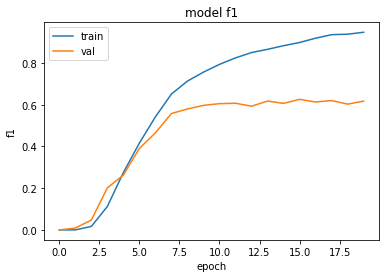

In [23]:
showplt(model)

**2) модель с 1 LSTM слоем**

In [24]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense_1 (Dense)             (None, 19)                2451      
                                                                 
Total params: 806,649
Trainable params: 806,649
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 5s 72ms/step - loss: 2.4747 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3185 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 2s 56ms/step - loss: 2.3119 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2993 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 3/20
43/43 [==============================] - 2s 57ms/step - loss: 2.1963 - f1: 8.7942e-04 - rec@prec: 0.0101 - val_loss: 2.2028 - val_f1: 0.0498 - val_rec@prec: 0.0054
Epoch 4/20
43/43 [==============================] - 2s 58ms/step - loss: 1.7601 - f1: 0.2228 - rec@prec: 0.0859 - val_loss: 1.6104 - val_f1: 0.3817 - val_rec@prec: 0.1438
Epoch 5/20
43/43 [==============================] - 2s 57ms/step - loss: 1.4586 - f1: 0.4896 - rec@prec: 0.2370 - val_loss: 1.5990 - val_f1: 0.4054 - val_rec@prec: 0.1186
Epoch 6/20
43/43 [==============================] - 2s 57ms/step - loss: 1.2814 - f1: 0.5805 - rec@prec: 0.39

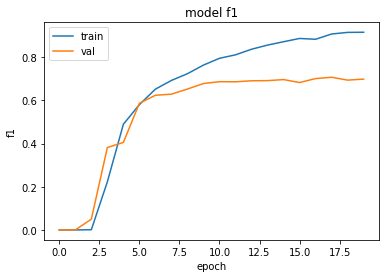

In [27]:
showplt(model)

**3) модель с 1 GRU и 1 LSTM слоем**

In [28]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_1)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [29]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 30)           722790    
                                                                 
 gru_1 (GRU)                 (None, 200, 128)          61440     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 19)                1235      
                                                                 
Total params: 925,305
Trainable params: 925,305
Non-trainab

In [30]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 12s 131ms/step - loss: 2.4962 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3287 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 5s 112ms/step - loss: 2.2769 - f1: 0.0000e+00 - rec@prec: 5.2209e-04 - val_loss: 2.1091 - val_f1: 0.0000e+00 - val_rec@prec: 0.0036
Epoch 3/20
43/43 [==============================] - 5s 113ms/step - loss: 1.9312 - f1: 0.0694 - rec@prec: 2.6105e-04 - val_loss: 1.8357 - val_f1: 0.1838 - val_rec@prec: 0.0081
Epoch 4/20
43/43 [==============================] - 5s 113ms/step - loss: 1.7201 - f1: 0.1894 - rec@prec: 0.0344 - val_loss: 1.9564 - val_f1: 0.2907 - val_rec@prec: 0.0848
Epoch 5/20
43/43 [==============================] - 5s 113ms/step - loss: 1.6001 - f1: 0.2654 - rec@prec: 0.1129 - val_loss: 1.6330 - val_f1: 0.3468 - val_rec@prec: 0.1222
Epoch 6/20
43/43 [==============================] - 5s 113ms/step - loss: 1.4404 - f1: 0.4002 - rec@prec: 0

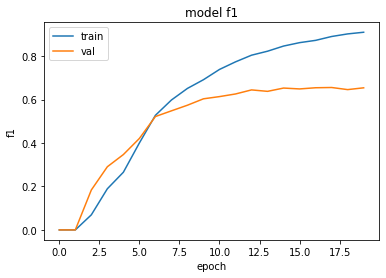

In [31]:
showplt(model)

**4) модель с 1 BIGRU и 2 LSTM слоями**

In [32]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [33]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 100)          2409300   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         176640    
 l)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          197120    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                           

In [34]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 18s 300ms/step - loss: 2.4435 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3225 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 12s 273ms/step - loss: 2.1404 - f1: 0.0189 - rec@prec: 0.0138 - val_loss: 1.8968 - val_f1: 0.1081 - val_rec@prec: 0.0555
Epoch 3/20
43/43 [==============================] - 12s 275ms/step - loss: 1.7616 - f1: 0.2077 - rec@prec: 0.1106 - val_loss: 1.6600 - val_f1: 0.2684 - val_rec@prec: 0.1411
Epoch 4/20
43/43 [==============================] - 12s 276ms/step - loss: 1.4729 - f1: 0.2916 - rec@prec: 0.1833 - val_loss: 1.5530 - val_f1: 0.3045 - val_rec@prec: 0.1907
Epoch 5/20
43/43 [==============================] - 12s 277ms/step - loss: 1.2788 - f1: 0.4664 - rec@prec: 0.2894 - val_loss: 1.3519 - val_f1: 0.5341 - val_rec@prec: 0.2813
Epoch 6/20
43/43 [==============================] - 12s 278ms/step - loss: 1.1387 - f1: 0.5955 - rec@prec: 0.4204 - val

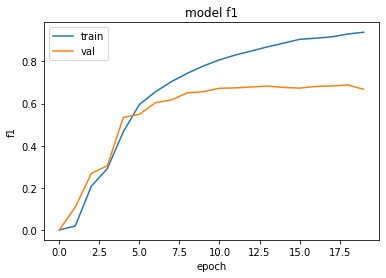

In [35]:
showplt(model)

**5) модель с 5 GRU слоями и 3 LSTM слоями**

In [43]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_2 = tf.keras.layers.GRU(64, return_sequences=True)(embeddings)
gru_3 = tf.keras.layers.GRU(64, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(64, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(64, return_sequences=True)(gru_4)
gru_6 = tf.keras.layers.GRU(64, return_sequences=True)(gru_5)
lstm_4 = tf.keras.layers.LSTM(64, return_sequences=True)(gru_6)
lstm_5 = tf.keras.layers.LSTM(64, return_sequences=True)(lstm_4)
lstm_6 = tf.keras.layers.LSTM(64, return_sequences=False)(lstm_5)

dense = tf.keras.layers.Dense(32, activation='relu')(lstm_6)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [44]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 30)           722790    
                                                                 
 gru_13 (GRU)                (None, 200, 64)           18432     
                                                                 
 gru_14 (GRU)                (None, 200, 64)           24960     
                                                                 
 gru_15 (GRU)                (None, 200, 64)           24960     
                                                                 
 gru_16 (GRU)                (None, 200, 64)           24960     
                                                                 
 gru_17 (GRU)                (None, 200, 64)           2496

In [45]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 20s 262ms/step - loss: 2.5315 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3682 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 9s 205ms/step - loss: 2.3400 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3242 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 9s 205ms/step - loss: 2.3240 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3215 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 9s 206ms/step - loss: 2.3212 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3073 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 9s 207ms/step - loss: 2.1071 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 1.9389 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
43/43 [==============================] - 9s 208m

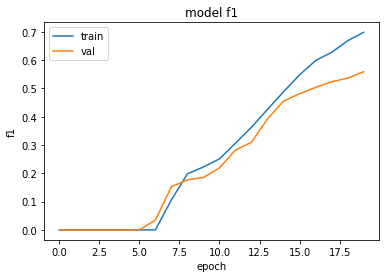

In [46]:
showplt(model)

**6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались**

In [47]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

gru_7 = tf.keras.layers.GRU(128, return_sequences=True)
gru_7_forward = gru_7(embeddings)
gru_7_backward = gru_7(embeddings[::-1])
gru_7_hidden = tf.keras.layers.concatenate([gru_7_forward, gru_7_backward])

lstm_7_forward = tf.keras.layers.LSTM(128, return_sequences=False)(gru_7_hidden)
lstm_7_backward = tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)(gru_7_hidden)
lstm_7_hidden = tf.keras.layers.concatenate([lstm_7_forward, lstm_7_backward])

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_7_hidden)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [48]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 200, 100)     2409300     ['input_8[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 200, 100)    0           ['embedding_7[0][0]']            
 ingOpLambda)                                                                                     
                                                                                                  
 gru_18 (GRU)                   (None, 200, 128)     88320       ['embedding_7[0][0]',      

In [49]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 21s 326ms/step - loss: 2.2734 - f1: 5.9083e-04 - rec@prec: 0.0000e+00 - val_loss: 1.9647 - val_f1: 0.0491 - val_rec@prec: 0.0252
Epoch 2/20
43/43 [==============================] - 13s 298ms/step - loss: 1.8695 - f1: 0.0785 - rec@prec: 0.0359 - val_loss: 1.7689 - val_f1: 0.1154 - val_rec@prec: 0.0708
Epoch 3/20
43/43 [==============================] - 13s 300ms/step - loss: 1.6702 - f1: 0.1868 - rec@prec: 0.0869 - val_loss: 1.6876 - val_f1: 0.1898 - val_rec@prec: 0.1032
Epoch 4/20
43/43 [==============================] - 13s 302ms/step - loss: 1.4938 - f1: 0.2954 - rec@prec: 0.1598 - val_loss: 1.9024 - val_f1: 0.1877 - val_rec@prec: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 13s 304ms/step - loss: 1.3936 - f1: 0.3987 - rec@prec: 0.1947 - val_loss: 1.6735 - val_f1: 0.4173 - val_rec@prec: 0.1362
Epoch 6/20
43/43 [==============================] - 13s 304ms/step - loss: 1.2550 - f1: 0.5383 - rec@prec: 0.2876 - val_los

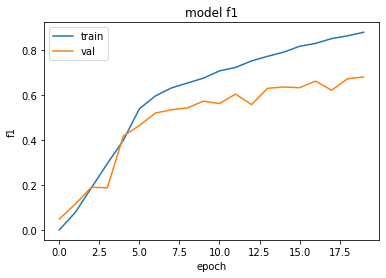

In [50]:
showplt(model)

**7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM**

In [51]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

lstm_8 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_8 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_8)
bilstm_9 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru_8)
bigru_9 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm_9)
gru_10 = tf.keras.layers.GRU(128, return_sequences=True)(bigru_9)
lstm_10 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_10)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_10)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [52]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 200, 100)          2409300   
                                                                 
 lstm_15 (LSTM)              (None, 200, 128)          117248    
                                                                 
 gru_19 (GRU)                (None, 200, 128)          99072     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         263168    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 256)         296448    
 nal)                                                      

In [53]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 35s 590ms/step - loss: 2.4591 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3247 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 23s 545ms/step - loss: 2.3241 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3210 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 24s 551ms/step - loss: 2.3229 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3192 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 24s 556ms/step - loss: 2.3222 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3129 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 24s 562ms/step - loss: 2.3155 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2039 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
43/43 [==============================] - 24s

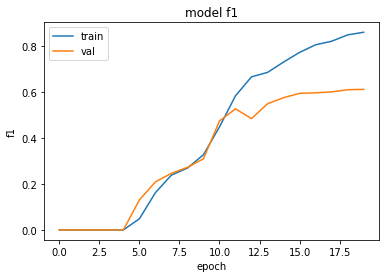

In [54]:
showplt(model)

У первых четырех моделей (1 GRU, 1 LSTM, 1 GRU + 1 LSTM, 1 BiGRU + 2 LSTM) динамика эффективности обучения с каждой эпохой примерно одинаковая: к 10 эпохе на валидации модель уже практически не показывает изменений, оставаясь на уровне 0.62-0.65. Похожая ситуация у модели 1 BiGRU + 1 BiLSTM, но чуть с более резкими перепадами показателей метрики. Модели с большим количеством слоев (5 GRU + 3 LSTM, LSTM + GRU + BiLSTM + BiGRU + GRU + LSTM) лучше обучаются (с каждой эпохой F1-мера на валидации постепенно растет), но результат ниже, чем у первых моделей. Если смотреть на показатель F1-меры на валидационной выборке, то лучшей оказывается модель с 1 LSTM слоем (val_f1: 0.6989).

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:

1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев;

2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [55]:
!pip install wget
!pip install datasets
!pip install pymorphy2

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=8c1e956651d54f6752d6fc2eeb2f0942fd61897845e899dd2ece6a87f318bead
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 342 kB 34.1 MB/s 
     |████████████████████████████████| 136 kB 13.0 MB/s 
     |████████████████████████████████| 212 kB 68.2 MB/s 
     |████████████████████████████████| 1.1 MB 12.9 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 127 kB 71.9 MB/s 
     |████████████████████████████████| 271 kB 63.3 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 56.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not current

     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 57.9 MB/s 


In [56]:
import wget
from datasets import load_dataset
from gensim.models import KeyedVectors
from gensim import models
from sklearn.metrics import classification_report

In [57]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Будем использовать предобученные эмбеддинги с [RusVectores](https://rusvectores.org/ru/models/) - tayga_none_fasttextcbow_300_10_2019. Так как для их обучения корпуса были лемматизированы, используем такую же предобработку для нашего датасета (с помощью pymorphy2 приведем токены к начальной форме). 

In [58]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [59]:
train_normal = []
for sent in dataset['train']['tokens']:
    train_normal.append([morph.parse(word)[0].normal_form for word in sent])

In [60]:
test_normal = []
for sent in dataset['test']['tokens']:
    test_normal.append([morph.parse(word)[0].normal_form for word in sent])

Собираем словарь, индексируем его, преобразуем тексты в последовательности индексов, проводим паддинг.

In [61]:
vocab = Counter()
for sent in train_normal:
    vocab.update([x.lower() for x in sent])

In [62]:
word2id = {'PAD': 0, 'UNK': 1}

for word in vocab:
    word2id[word] = len(word2id)

In [63]:
id2word = {i: word for word, i in word2id.items()}

In [64]:
X = []

for sent in train_normal:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [65]:
X_test = []

for sent in test_normal:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [66]:
MAX_LEN = max(len(x) for x in X)

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

Проводим паддинг последовательностей тегов, чтобы длина совпадала с длиной последовательностей токенов.

In [67]:
id2labels = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'PAD'}
label2id = {v: k for k, v in id2labels.items()}

In [68]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN, padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN, padding='post')

Скачиваем предобученные эмбеддинги, сохраняем веса в переменную weigths.

In [69]:
wget.download('http://vectors.nlpl.eu/repository/20/187.zip')

'187.zip'

In [70]:
import zipfile
with zipfile.ZipFile('187.zip', 'r') as obj:
    obj.extractall('temp')

In [71]:
model_path = '/content/temp/model.model'
pretrained_model = models.KeyedVectors.load(model_path)

In [72]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = pretrained_model[word]
    except AttributeError:
      continue

Параметры модели с предобученными эмбеддингами (устанавливаем параметр trainable=False). Модель с двумя BiLSTM слоями.

In [73]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=False,
                                       weights=[weights])(inputs)

bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm_2)

model_bilstm = tf.keras.Model(inputs=inputs, outputs=outputs)
model_bilstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [74]:
model_bilstm.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5)

Epoch 1/5
157/157 [==============================] - 12s 35ms/step - loss: 0.2139 - accuracy: 0.9459 - val_loss: 0.1174 - val_accuracy: 0.9636
Epoch 2/5
157/157 [==============================] - 4s 26ms/step - loss: 0.0925 - accuracy: 0.9707 - val_loss: 0.1029 - val_accuracy: 0.9677
Epoch 3/5
157/157 [==============================] - 4s 27ms/step - loss: 0.0774 - accuracy: 0.9751 - val_loss: 0.0916 - val_accuracy: 0.9711
Epoch 4/5
157/157 [==============================] - 4s 27ms/step - loss: 0.0665 - accuracy: 0.9784 - val_loss: 0.0889 - val_accuracy: 0.9721
Epoch 5/5
157/157 [==============================] - 4s 27ms/step - loss: 0.0589 - accuracy: 0.9807 - val_loss: 0.0897 - val_accuracy: 0.9728


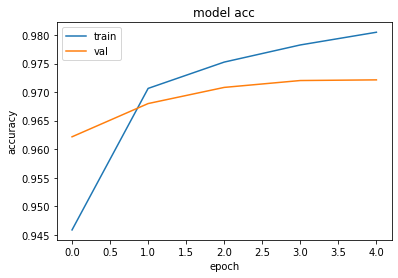

In [ ]:
plt.plot(model_bilstm.history.history['accuracy'])
plt.plot(model_bilstm.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Вторая модель с предобученными эмбеддингами с двумя BiGRU слоями.

In [75]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=False,
                                       weights=[weights])(inputs)

bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_2)

model_bigru = tf.keras.Model(inputs=inputs, outputs=outputs)
model_bigru.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [76]:
model_bigru.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5)

Epoch 1/5
157/157 [==============================] - 10s 31ms/step - loss: 0.2278 - accuracy: 0.9498 - val_loss: 0.1119 - val_accuracy: 0.9652
Epoch 2/5
157/157 [==============================] - 4s 24ms/step - loss: 0.0876 - accuracy: 0.9720 - val_loss: 0.0986 - val_accuracy: 0.9693
Epoch 3/5
157/157 [==============================] - 4s 23ms/step - loss: 0.0738 - accuracy: 0.9763 - val_loss: 0.0921 - val_accuracy: 0.9707
Epoch 4/5
157/157 [==============================] - 4s 23ms/step - loss: 0.0647 - accuracy: 0.9790 - val_loss: 0.0909 - val_accuracy: 0.9718
Epoch 5/5
157/157 [==============================] - 4s 24ms/step - loss: 0.0588 - accuracy: 0.9808 - val_loss: 0.0884 - val_accuracy: 0.9731


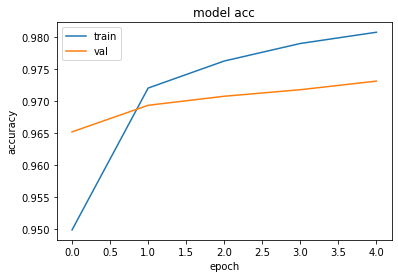

In [77]:
plt.plot(model_bigru.history.history['accuracy'])
plt.plot(model_bigru.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Сохраняем предсказания модели и выводим classification report.

In [78]:
pred_bilstm = model_bilstm.predict(X_test).argmax(2)

In [79]:
pred_bigru = model_bigru.predict(X_test).argmax(2)

In [80]:
print(classification_report(y_test.reshape(-1), pred_bilstm.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.88      0.86      0.87     40480
       B-PER       0.78      0.88      0.83      3542
       I-PER       0.78      0.91      0.84      7544
       B-ORG       0.78      0.59      0.67      4074
       I-ORG       0.84      0.70      0.76      8008
       B-LOC       0.85      0.70      0.77      4560
       I-LOC       0.88      0.65      0.75      3060
         PAD       0.99      1.00      0.99    468732

    accuracy                           0.97    540000
   macro avg       0.85      0.79      0.81    540000
weighted avg       0.97      0.97      0.97    540000



In [81]:
print(classification_report(y_test.reshape(-1), pred_bigru.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.84      0.89      0.87     40480
       B-PER       0.91      0.78      0.84      3542
       I-PER       0.90      0.81      0.85      7544
       B-ORG       0.78      0.60      0.68      4074
       I-ORG       0.83      0.71      0.76      8008
       B-LOC       0.86      0.68      0.76      4560
       I-LOC       0.84      0.68      0.75      3060
         PAD       0.99      1.00      0.99    468732

    accuracy                           0.97    540000
   macro avg       0.87      0.77      0.81    540000
weighted avg       0.97      0.97      0.97    540000



По F1-мере модели практически не отличаются. У BiLSTM-модели выше полнота для тегов PER и B-LOC, тогда как у BiGRU модели выше точность (в особенности для тегов PER). Посмотрим на несколько примеров. Так как для построения модели проводилась лемматизация, в предобработку текста необходимо добавить этот пункт.

In [82]:
import re

def preprocess(text, word2id):
    tokens = re.findall('\w+|[^\w\s]+', text)
    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    ids = [word2id.get(lemma.lower(), 1) for lemma in lemmas]
    return tokens, ids

def pred2tags(pred, id2label, length):
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = preprocess(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    return list(zip(tokens, labels))

In [83]:
text_1 = 'Олег Тиньков опубликовал в своем инстаграме пост, в котором попрощался с Тинькофф банком и Россией'
text_2 = 'Йенс Столтенберг назначен главой Банка Норвегии'
text_3 = 'На Венецианском кинофестивале показали документальный фильм шведского режиссера Натана Гроссмана о Грете Тунберг'

In [84]:
display(label_seq(text_1, word2id, id2labels, MAX_LEN, model_bilstm))
display(label_seq(text_1, word2id, id2labels, MAX_LEN, model_bigru))

[('Олег', 'B-PER'),
 ('Тиньков', 'O'),
 ('опубликовал', 'O'),
 ('в', 'O'),
 ('своем', 'O'),
 ('инстаграме', 'O'),
 ('пост', 'O'),
 (',', 'O'),
 ('в', 'O'),
 ('котором', 'O'),
 ('попрощался', 'O'),
 ('с', 'O'),
 ('Тинькофф', 'O'),
 ('банком', 'B-ORG'),
 ('и', 'O'),
 ('Россией', 'B-LOC')]

[('Олег', 'B-PER'),
 ('Тиньков', 'I-PER'),
 ('опубликовал', 'O'),
 ('в', 'O'),
 ('своем', 'O'),
 ('инстаграме', 'O'),
 ('пост', 'O'),
 (',', 'O'),
 ('в', 'O'),
 ('котором', 'O'),
 ('попрощался', 'O'),
 ('с', 'O'),
 ('Тинькофф', 'O'),
 ('банком', 'O'),
 ('и', 'O'),
 ('Россией', 'B-LOC')]

In [85]:
display(label_seq(text_2, word2id, id2labels, MAX_LEN, model_bilstm))
display(label_seq(text_2, word2id, id2labels, MAX_LEN, model_bigru))

[('Йенс', 'B-PER'),
 ('Столтенберг', 'O'),
 ('назначен', 'O'),
 ('главой', 'O'),
 ('Банка', 'B-ORG'),
 ('Норвегии', 'I-ORG')]

[('Йенс', 'B-PER'),
 ('Столтенберг', 'O'),
 ('назначен', 'O'),
 ('главой', 'O'),
 ('Банка', 'B-ORG'),
 ('Норвегии', 'I-ORG')]

In [86]:
display(label_seq(text_3, word2id, id2labels, MAX_LEN, model_bilstm))
display(label_seq(text_3, word2id, id2labels, MAX_LEN, model_bigru))

[('На', 'O'),
 ('Венецианском', 'O'),
 ('кинофестивале', 'O'),
 ('показали', 'O'),
 ('документальный', 'O'),
 ('фильм', 'O'),
 ('шведского', 'O'),
 ('режиссера', 'O'),
 ('Натана', 'B-PER'),
 ('Гроссмана', 'I-PER'),
 ('о', 'O'),
 ('Грете', 'B-PER'),
 ('Тунберг', 'PAD')]

[('На', 'O'),
 ('Венецианском', 'O'),
 ('кинофестивале', 'O'),
 ('показали', 'O'),
 ('документальный', 'O'),
 ('фильм', 'O'),
 ('шведского', 'B-PER'),
 ('режиссера', 'O'),
 ('Натана', 'B-PER'),
 ('Гроссмана', 'I-PER'),
 ('о', 'O'),
 ('Грете', 'B-PER'),
 ('Тунберг', 'I-PER')]

BiLSTM модель верно определила как именнованную сущность банк, но пометила почему-то именно слово "банк", а не "Тинькофф", для персоны "Олег Тиньков" нашла только имя, а для "Греты Тунберг" неправильно присвоила тег "PAD" фамилии. BiGRU модель не определила "Тинькофф банк" и отдельно приняла "шведского" за именнованную сущность. Обе модели не присвоили тег "I-PER" фамилии "Столтенберг" и не присвоили именнованных тегов "Венецианскому кинофестивалю".